[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/probabilistic_python/blob/master/pymc_intro.ipynb)

# Building Models in PyMC


Probabilistic programming (PP) allows flexible specification of Bayesian statistical models in code. PyMC is an open-source PP framework with an intuitive and readable, yet powerful, syntax that is close to the natural syntax statisticians use to describe models. It features next-generation Markov chain Monte Carlo (MCMC) sampling algorithms such as the No-U-Turn Sampler (NUTS; Hoffman, 2014), a self-tuning variant of Hamiltonian Monte Carlo (HMC; Duane, 1987). This class of samplers works well on high dimensional and complex posterior distributions and allows many complex models to be fit without specialized knowledge about fitting algorithms. HMC and NUTS take advantage of gradient information from the likelihood to achieve much faster convergence than traditional sampling methods, especially for larger models. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo, which means you usually don't need to have specialized knowledge about how the algorithms work. 

Let's start by looking at a fully-specified model, to give you an idea of what we are building towards.



### Example: Parametric Survival Model

Survival models are used to estimate expected event times, often in biomedical settings. Survival data is characterized by the presence of censoring, where subject drop out of the study system before the event of interest occurs, or the study ends before events occur to all subjects. There are two components to the model likelihood: one that describes the observed events, and the other that describes the censoring (the fact that the event occurs sometime after the last observation).

This example models the survival of cancer patients, using metastization (`X`) as a covariate and censoring (`censored`) as a binary indicator:

```python
with pm.Model() as weibull_model:

    # Survival covariates
    beta = pm.Normal("beta", mu=0., sigma=10., shape=2)
    eta = beta.dot(X.T)

    # Observation noise
    s = pm.HalfNormal("s", 5.0)

    # Survival function
    y_obs = pm.Gumbel("y_obs", eta[~censored], s, observed=y_std[~censored])

    def gumbel_sf(y, m, s):
        return 1.0 - tt.exp(-tt.exp(-(y - m) / s))

    # Censored likelihood
    y_cens = pm.Potential("y_cens", gumbel_sf(y_std[censored], eta[censored], s))

```

For our purposes, its not important to undestand the details of survival modeling (the topic of entire university courses!). I'm using this example because it includes all of the building blocks of Bayesian models, as implemented in PyMC. 

In [46]:
import seaborn as sns
import numpy as np
import pymc as pm
import arviz as az
from statsmodels import datasets

df = datasets.get_rdataset("mastectomy", "HSAUR", cache=True).data.assign(
    metastized=lambda df: 1.0 * (df.metastized == "yes"), event=lambda df: 1.0 * df.event
)

n_patient, _ = df.shape

X = np.empty((n_patient, 2))
X[:, 0] = 1.0
X[:, 1] = df.metastized

y = np.log(df.time.values)
y_std = (y - y.mean()) / y.std()

censored = df.event.values == 0.0


In statistical notation, this model is represented as follows:

$$S(t\ |\ \beta, \mathbf{x}) = S_0\left(\exp\left(\beta^{\top} \mathbf{x}\right) \cdot t\right),$$
$$\beta \sim N(0, 5^2 I_2)$$

$$-\log(S_0)=\left\{
\begin{array}{ll}
P(Y \geq y) = 1 - \exp\left(-\exp\left(-\frac{y - \mu}{s}\right)\right) & \text{if censored} \\
Y \sim \textrm{Gumbel}(\eta, s) & \text{otherwise}
\end{array}\right.$$
$$s \sim \textrm{HalfNormal}(5)$$

At the model-specification stage (before the data are observed), $Y$, $\beta$,and $s$ are all random variables. Bayesian "random" variables have not necessarily arisen from a physical random process. The Bayesian interpretation of probability is **epistemic**, meaning random variable $x$'s probability distribution $p(x)$ represents our knowledge and uncertainty about $x$'s value. Candidate values of $x$ for which $p(x)$ is high are relatively more probable, given what we know. 

We can generally divide the variables in a Bayesian model into two types: **stochastic** and **deterministic**. The only deterministic variable in this model is `eta`. If we knew the values of `eta`'s parents, we could compute the value of `eta` exactly. A deterministic like `eta` is defined by a mathematical function that returns its value given values for its parents. Deterministic variables are sometimes called the *systemic* part of the model. The nomenclature is a bit confusing, because these objects usually represent random variables; since the parents of `eta` are random, `eta` is random also.

On the other hand, even if the values of the parents of variables `beta` or `s` were known, we would still be uncertain of their values. These variables are stochastic, characterized by probability distributions that express how plausible their candidate values are, given values for their parents.


## Stochastic Random Variables

Let's start at the top of the model, with the first stochastic variable `beta`:

In [6]:
with pm.Model() as weibull_model:

    beta = pm.Normal("beta", mu=0., sigma=10., shape=2)

We have done two things here. First, we have created a `Model` object; a `Model` is a Python object that encapsulates all of the variables that comprise our theoretical model, keeping them in a single container so that they may be used as a unit. After a `Model` is created, we can populate it with all of the model components that we specified when we wrote the model down. 

Notice that the `Model` above was declared using a `with` statement. This expression is used to define a Python idiom known as a **context manager**. Context managers, in general, are used to manage resources of some kind within a program. In this case, our resource is a `Model`, and we would like to add variables to it so that we can fit our statistical model. The key characteristic of the context manager is that the resources it manages are only defined within the indented block corresponding to the `with` statement. PyMC uses this idiom to automatically add defined variables to a model. Thus, any variable we define is automatically added to the `Model`, without having to explicitly add it.

As an analogy, `Model` is a tape machine that records what is being added to the model; it keeps track the random variables (observed or unobserved) and other model components. The model context then computes some simple model properties, builds a **bijection** mapping that transforms between Python dictionaries and numpy/Aesara ndarrays. , More importantly, a `Model` contains methods to compile Aesara functions that take Random Variables--that are also initialised within the same model--as input.

In fact, PyMC variables cannot be defined without a corresponding `Model`:

In [7]:
beta = pm.Normal("beta", mu=0., sigma=10., shape=2)

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

A stochastic variable is represented in PyMC by a `Distribution` class. This structure extens Aesara's `TensorVariable` class, mainly by registering it with an associated PyMC `Model`. 

In [10]:
type(beta)

aesara.tensor.var.TensorVariable

All of the `Distribution` subclasses included in PyMC will have two key methods, `random()` and `logp()`, which are used to generate random values and compute the log-probability of a value, respectively.

```python
class SomeDistribution(Continuous):
    def __init__(...):
        ...

    def random(self, point=None, size=None):
        ...
        return random_samples

    def logp(self, value):
        ...
        return total_log_prob
```

PyMC expects the `logp()` method to return a log-probability evaluated at the passed `value` argument. This method is used internally by all of the inference methods to calculate the model log-probability that is used for fitting models. 

The `logp` method is only used internally by PyMC; should you wish to calculate a log-probability manually, use the `pm.logp` function instead:

In [25]:
pm.logp(beta, 1).eval()

array(-3.22652363)

The `random()` method is used to simulate values from the variable, and is used internally for posterior predictive checks. Similarly, to manually generate values from PyMC variables, use the `pm.draw` function:

In [28]:
pm.draw(beta, 3)

array([[-7.22163405,  0.56011825],
       [22.45748477,  4.24599471],
       [ 7.36214462,  0.49011792]])

`Distribution` has a classmethod `dist` that returns a **stateless** probability distribution of that type; that is, without being wrapped in a PyMC random variable object. Sometimes we wish to use a particular statistical distribution, without using it as a variable in a model; for example, to generate random numbers from the distribution. 

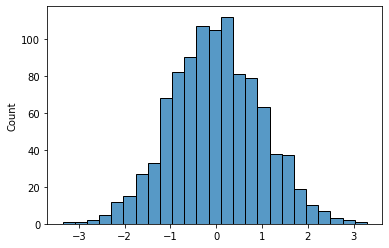

In [13]:
x = pm.Normal.dist(mu=0, sigma=1, size=1000)
sns.histplot(x.eval());

PyMC includes most of the probability density functions (for continuous variables) and probability mass functions (for discrete variables) used in statistical modeling. These distributions are divided into five distinct categories:

* Univariate continuous
* Univariate discrete
* Multivariate
* Mixture
* Timeseries

Probability distributions are all subclasses of `Distribution`, which in turn has two major subclasses: `Discrete` and `Continuous`. In terms of data types, a `Continuous` random variable is given whichever floating point type is defined by `aesara.config.floatX`, while `Discrete` variables are given `int16` types when `aesara.config.floatX` is `float32`, and `int64` otherwise.

In [14]:
pm.distributions.__all__

['Uniform',
 'Flat',
 'HalfFlat',
 'TruncatedNormal',
 'Normal',
 'Beta',
 'Kumaraswamy',
 'Exponential',
 'Laplace',
 'StudentT',
 'Cauchy',
 'HalfCauchy',
 'Gamma',
 'Weibull',
 'Bound',
 'LogNormal',
 'Lognormal',
 'HalfStudentT',
 'ChiSquared',
 'HalfNormal',
 'Wald',
 'Pareto',
 'InverseGamma',
 'ExGaussian',
 'VonMises',
 'Binomial',
 'BetaBinomial',
 'Bernoulli',
 'Poisson',
 'NegativeBinomial',
 'Constant',
 'ZeroInflatedPoisson',
 'ZeroInflatedNegativeBinomial',
 'ZeroInflatedBinomial',
 'DiscreteUniform',
 'Geometric',
 'HyperGeometric',
 'Categorical',
 'OrderedLogistic',
 'OrderedProbit',
 'DensityDist',
 'Distribution',
 'SymbolicDistribution',
 'Continuous',
 'Discrete',
 'NoDistribution',
 'MvNormal',
 'MatrixNormal',
 'KroneckerNormal',
 'MvStudentT',
 'Dirichlet',
 'StickBreakingWeights',
 'Multinomial',
 'DirichletMultinomial',
 'OrderedMultinomial',
 'Wishart',
 'WishartBartlett',
 'LKJCholeskyCov',
 'LKJCorr',
 'AR',
 'AsymmetricLaplace',
 'GaussianRandomWalk',
 'Mv

Notice that while the `beta` variable is osensibly a univariate random variable, being normal, it has a shape of 2, meaning that it is a "batch" of similar random variables (i.e. linear model coefficients).

In [21]:
beta.shape.eval()

array([2])

While we are defining our priors, let's also add the prior for `s`, the observation noise parameter.

In [15]:
with weibull_model:

    s = pm.HalfNormal("s", 5.0)

Notice that we have "re-opened" the `weibull_model` in a new context manager, which allows us to add additional variables.

Internally, the model is keeping track of the types of variables that are being added:

In [22]:
weibull_model.unobserved_RVs

[beta ~ N(0, 10), s ~ N**+(0, 5)]

### Auto-transformation

To support efficient sampling by PyMC's MCMC algorithms, any continuous variables that are constrained to a sub-interval of the real line are automatically transformed so that their support is unconstrained. This frees sampling algorithms from having to deal with boundary constraints.

For example, the half-normal distribution is positive-valued.

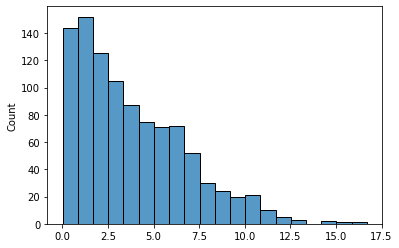

In [37]:
sns.histplot(pm.draw(s, 1000));

In [38]:
pm.logp(s, -1).eval()

array(-inf)

If we inspect the model's `value_vars` attribute, which contains the values of each random variable actually used by the model's log-likelihood:


In [ ]:
weibull_model.value_vars

[beta, s_log__]

As the name suggests, the variable ``s`` has been log-transformed, and this is the space over which posterior sampling takes place. When a sample is drawn, the value of the transformed variable is simply back-transformed to recover the original variable.

By default, auto-transformed variables are ignored when summarizing and plotting model output, since they are not generally of interest to the user.

## Deterministic Variables

A deterministic variable is one whose values are **completely determined** by the values of their parents. The variable `eta` is a linear combination of the predictor variable and the coefficients, with no inherent randomness beyond what is inherited from them. 

In [19]:
with weibull_model:

    eta = beta.dot(X.T)

Notice that `eta` is **anonymous** as it has not been given a name or a formal PyMC data structure, like the stochastic priors have. It is essentially an **intermediate calculation** in the model, implying that we are not interested in its value when it comes to summarizing the output from the model. Most PyMC objects have a name assigned; these names are used for storage and post-processing:

-   as keys in output databases,
-   as axis labels in plots of traces,
-   as table labels in summary statistics.

If we wish to include `eta` in our output, we need to make it a `Deterministic` object, and give it a name:

```python
with weibull_model:

    eta = pm.Deterministic('eta', beta.dot(X.T))
```

In [20]:
eta.shape.eval()

array([44])

## Observed Random Variables

Stochastic random variables whose values are observed (*i.e.* data likelihoods) are represented by a different class than unobserved random variables. A `ObservedRV` object is instantiated any time a stochastic variable is specified with data passed as the `observed` argument. 

In [32]:
with weibull_model:

        y_obs = pm.Gumbel("y_obs", eta[~censored], s, observed=y_std[~censored])

In [34]:
weibull_model.observed_RVs

[y_obs ~ Gumbel(f(beta), s)]

In [ ]:
import numpy as np

with pm.Model():
    
    def uniform_logp(value, lower=0, upper=111):
        """The switchpoint for the rate of disaster occurrence."""
        return pm.math.switch((value > upper) | (value < lower), -np.inf, -np.log(upper - lower + 1))

    switchpoint = pm.DensityDist('switchpoint', logp=uniform_logp, dtype='int64')

In [ ]:
pm.logp(switchpoint, 4).eval()

In [ ]:
pm.logp(switchpoint, 44).eval()

In [ ]:
pm.logp(switchpoint, -4).eval()

A couple of things to notice: while the function specified for the `logp` argument can be an arbitrary Python function, it must use **Aesara operators and functions** in its body. This is because one or more of the arguments passed to the function may be `TensorVariables`, and they must be supported. 

To emphasize, the Python function passed to `DensityDist` should compute the *log*-density or *log*-probability of the variable. That is why the return value in the example above is `-log(upper-lower+1)` rather than `1/(upper-lower+1)`.

In [ ]:
with disaster_model:
    
    disasters = pm.Poisson('disasters', mu=3, observed=[3,4,1,2,0,2,2])

An important responsibility of `ObservedRV` is to automatically handle missing values in the data, when they are present (absent?). More on this later.

## Factor Potentials

For some applications, we want to be able to modify the joint density by incorporating terms that don't correspond to probabilities of variables conditional on parents, for example:

$$p(x_0, x_2, \ldots x_{N-1}) \propto \prod_{i=0}^{N-2} \psi_i(x_i, x_{i+1})$$

In other cases we may want to add probability terms to existing models. We call such log-probability terms **factor potentials** (Jordan 2004). Bayesian hierarchical notation doesn't accomodate these potentials. 

### Creation of Potentials

A potential can be created via the `Potential` function, in a way very similar to `Deterministic`'s named interface. In our survival model, we have a log-probability that is required to account for censoring in the data. This probability function can be defined as a standard Python function, and then wrapped by `Potential`:

In [41]:
with weibull_model:
    
    def gumbel_sf(y, m, s):
        return 1.0 - pm.math.exp(-pm.math.exp(-(y - m) / s))

    y_cens = pm.Potential("y_cens", gumbel_sf(y_std[censored], eta[censored], s))

The function takes just a `name` as its first argument and an expression returning the appropriate log-probability as the second argument.

A `Potential` has a log-probability but no value; compare this to a `Deterministic` node, which has a value but no log-probability, and a `Distribution` which has both.

An alternative to using a factor potential is to create a custom distribution from the log-probability function. If you have a well-behaved density function, we can use it in a model to build a model log-likelihood function. Almost any Aesara function can be turned into a distribution using the `DensityDist` function.

This is achieved by 

```python
def gumbel_sf(value, m, s):
        return 1.0 - pm.math.exp(-pm.math.exp(-(value - m) / s))

y_cens = pm.DensityDist('y_cens', eta[censored], s, logp=gumbel_sf, observed=y)
```

This will result in an observed random variable that will include a value attribute, and potentially a `random` method (though we have not specified one here). Its probably overkill for our purposes here, however.

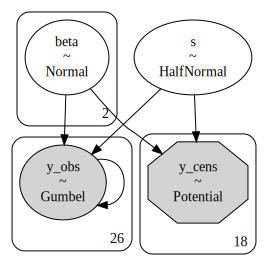

In [43]:
pm.model_to_graphviz(weibull_model)

In [44]:
with weibull_model:

    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


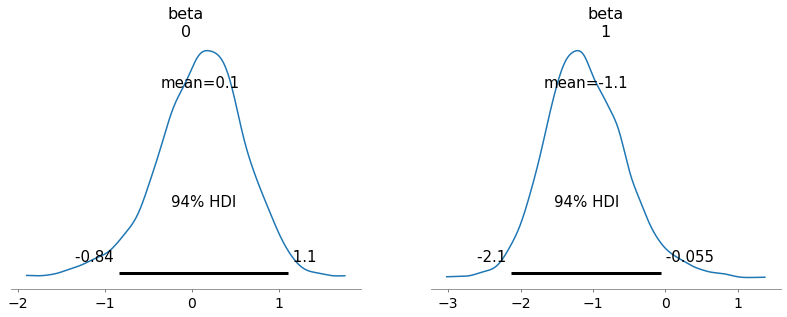

In [47]:
az.plot_posterior(trace, var_names=["beta"]);

---

## To Learn More

- C.D. Pilon. [Probabilistic Programming & Bayesian Methods for Hackers](https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)
- M.I. Jordan. 2004. Graphical models. Statist. Sci., 19(1):140–155.
- **Hoffman, M. D., and A. Gelman. (2014)**. The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo. Journal of Machine Learning Research: JMLR 15 (1): 1593–1623.
